In [1]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import covariance_generation
import transformation_constants
import data_analysis
from mcmc_plots import *
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd

In [2]:
dr3_path = '/local/mariacst/2022_v0_project/data/GaiaDR3_RV_RGB_fidelity.csv'
gaia_dr3 = pd.read_csv(dr3_path)
gaia_dr3.columns

Index(['Unnamed: 0', 'source_id', 'ra', 'dec', 'rgeo', 'b_rgeo', 'B_rgeo',
       'r_est', 'b_rpgeo', 'B_rpgeo', 'ra_error', 'dec_error', 'parallax',
       'parallax_error', 'PM', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'Gmag', 'BPmag', 'RPmag', 'BP-RP', 'radial_velocity',
       'radial_velocity_error', 'Vbroad', 'GRVSmag', 'Gal', 'Teff', 'logg',
       '[Fe/H]', 'Dist', 'A0', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000',
       'RADEcorJ2000', 'ra_dec_corr', 'ra_pmdec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'B_Teff', 'b_Teff', 'b_logg', 'B_logg', 'b_Dist',
       'B_Dist', 'b_AG', 'B_AG', 'b_A0', 'B_A0', 'dec_pmra_corr',
       'dec_pmdec_corr', 'dec_parallax_corr', 'parallax_pmdec_corr',
       'parallax_pmra_corr', 'pmra_pmdec_corr'],
      dtype='object')

In [3]:
def load_galactic_parameters():
   
   # Initial Galactocentric distance
   r_0 = 8277

   # Initial height over Galactic plane
   z_0 = 25

   # Initial solar vector
   v_sun = transformation_constants.V_SUN
   v_sun[0][0] = 11.1
   v_sun[1][0] = 251.5
   v_sun[2][0] = 8.59
   
   return r_0, z_0, v_sun
r_0, z_0, v_sun = load_galactic_parameters()


def apply_initial_cut(icrs_data):

   r_0, z_0, v_sun = load_galactic_parameters()

   galcen_data = data_analysis.get_transformed_data(icrs_data,
                                          include_cylindrical = True,
                                          z_0 = z_0,
                                          r_0 = r_0,
                                          v_sun = v_sun,
                                          debug = True,
                                          is_bayes = True,
                                          is_source_included = True)

   # galactocentric_cov = cov.generate_galactocentric_covmat(icrs_data, 
   #                                                             is_bayes = True,
   #                                                             Z_0 = z_0,
   #                                                             R_0 = r_0)

   # cyl_cov = cov.transform_cov_cylindirical(galcen_data, 
   #                                              C = galactocentric_cov,
   #                                              Z_0 = z_0,
   #                                              R_0 = r_0)
   # galcen_data = galcen_data.merge(cyl_cov, on='source_id')


   # Final data cut
   galcen_data = galcen_data[(galcen_data.r < 15000) & (galcen_data.r > 5000)]
   galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]


   # Remove halo stars (condition taken from 1806.06038)                        
   v_dif = np.linalg.norm(np.array([galcen_data.v_x, galcen_data.v_y, galcen_data.v_z])-v_sun,
                        axis=0)                                               
   galcen_data['v_dif'] = v_dif                                                 
   galcen_data = galcen_data[galcen_data.v_dif<210.]

   galcen_data.reset_index(inplace=True, drop=True)
   
   return galcen_data


galcen_data = apply_initial_cut(gaia_dr3)
# galcen_data = data_analysis.get_transformed_data(gaia_dr3,
#                                         include_cylindrical = True,
#                                         z_0 = z_0,
#                                         r_0 = r_0,
#                                         v_sun = v_sun,
#                                         debug = True,
#                                         is_bayes = True,
#                                         is_source_included = True)

Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 8.653688484802842 sec


In [4]:
galcen_data.shape

(1679257, 12)

In [5]:
gaia_dr3 = gaia_dr3.merge(galcen_data, on='source_id')[gaia_dr3.columns]

In [6]:
gaia_dr3.shape

(1679257, 58)

In [7]:
r_est_error = (gaia_dr3.B_rpgeo - gaia_dr3.b_rpgeo)/2
gaia_dr3['r_est_error'] = r_est_error

In [36]:
gaia_dr3.columns[0]

'source_id'

### Cleaning the dataset

In [8]:
gaia_dr3 = gaia_dr3.drop(columns=['Unnamed: 0'])

In [9]:
columns_to_drop = ['Vbroad', 'GRVSmag', 'Gal', 'Teff', 'logg',
       '[Fe/H]', 'Dist', 'A0', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000',
       'RADEcorJ2000', 'B_Teff', 'b_Teff', 'b_logg', 'B_logg', 'b_Dist',
       'B_Dist', 'b_AG', 'B_AG', 'b_A0', 'B_A0', 'Gmag', 'BPmag', 'RPmag', 'BP-RP']

In [10]:
gaia_dr3 = gaia_dr3.drop(columns=columns_to_drop)

In [11]:
gaia_dr3.columns

Index(['source_id', 'ra', 'dec', 'rgeo', 'b_rgeo', 'B_rgeo', 'r_est',
       'b_rpgeo', 'B_rpgeo', 'ra_error', 'dec_error', 'parallax',
       'parallax_error', 'PM', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'radial_velocity', 'radial_velocity_error', 'ra_dec_corr',
       'ra_pmdec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'dec_parallax_corr', 'parallax_pmdec_corr',
       'parallax_pmra_corr', 'pmra_pmdec_corr', 'r_est_error'],
      dtype='object')

In [12]:
gaia_dr3.to_csv('/local/sven/v0_project_archive/Poder_vc_DR3_input.csv', index=False)

### Problem 2: Huge errors!

In [63]:
print(np.mean(gaia_dr3['r_est_error']))
print(np.max(gaia_dr3['r_est_error']))

195.9545844697522
4963.78124


In [64]:
C_icrs_new = covariance_generation.generate_covmat(gaia_dr3)
C_icrs_old = covariance_generation.generate_covmat(gaia_dr3, is_parallax=True)

In [65]:
#r_est
print(np.mean(C_icrs_new[:, 2, 2]))
print(np.mean(C_icrs_old[:, 2, 2]))

#mu_ra
print(np.mean(C_icrs_new[:, 3, 3]))
print(np.mean(C_icrs_old[:, 3, 3]))

# mu_dec
print(np.mean(C_icrs_new[:, 4, 4]))
print(np.mean(C_icrs_old[:, 4, 4]))

# v_los
print(np.mean(C_icrs_new[:, 5, 5]))
print(np.mean(C_icrs_old[:, 5, 5]))

90010.03617060908
0.000718048964360473
0.0007660913094729592
0.0007660913094729592
0.0006401363585947142
0.0006401363585947142
10.028507836884629
10.028507836884629


In [66]:
# CUT ON DATA

#r_est
print(np.mean(C_icrs_new[:, 2, 2]))
print(np.mean(C_icrs_old[:, 2, 2]))

#mu_ra
print(np.mean(C_icrs_new[:, 3, 3]))
print(np.mean(C_icrs_old[:, 3, 3]))

# mu_dec
print(np.mean(C_icrs_new[:, 4, 4]))
print(np.mean(C_icrs_old[:, 4, 4]))

# v_los
print(np.mean(C_icrs_new[:, 5, 5]))
print(np.mean(C_icrs_old[:, 5, 5]))

90010.03617060908
0.000718048964360473
0.0007660913094729592
0.0007660913094729592
0.0006401363585947142
0.0006401363585947142
10.028507836884629
10.028507836884629


In [67]:
Z_0 = 25
R_0 = 8277

In [68]:
data_array = gaia_dr3[["ra", "dec","r_est","pmra","pmdec","radial_velocity"]].to_numpy()
C_icrs_new_galcen = covariance_generation.transform_cov_matrix(C_icrs_new, data_array, "Cartesian", Z_0, R_0, is_bayes=True)
C_icrs_old_galcen = covariance_generation.transform_cov_matrix(C_icrs_old, data_array, "Cartesian", Z_0, R_0, is_bayes=True)

In [69]:
#v_x
print(np.sqrt(np.mean(C_icrs_new_galcen[:, 3, 3])))
print(np.sqrt(np.mean(C_icrs_old_galcen[:, 3, 3])))

# v_y
print(np.sqrt(np.mean(C_icrs_new_galcen[:, 4, 4])))
print(np.sqrt(np.mean(C_icrs_old_galcen[:, 4, 4])))

6.770241882067479
2.478354287373753
5.417093237088667
2.001227147084019


In [70]:
data_array = galcen_data[["x", "y","r","phi","v_r","v_phi"]].to_numpy()
C_new_cylindrical = covariance_generation.transform_cov_matrix(C_icrs_new_galcen, data_array, "Cylindrical", Z_0, R_0)
C_old_cylindrical = covariance_generation.transform_cov_matrix(C_icrs_old_galcen, data_array, "Cylindrical", Z_0, R_0)

In [71]:
#v_r
print(np.sqrt(np.mean(C_new_cylindrical[:, 3, 3])))
print(np.sqrt(np.mean(C_old_cylindrical[:, 3, 3])))

# v_phi
print(np.sqrt(np.mean(C_new_cylindrical[:, 4, 4])))
print(np.sqrt(np.mean(C_old_cylindrical[:, 4, 4])))

4.067362810996218
2.190342933833176
4.13638686284668
2.31290685306065


### Error distributions

Text(0, 0.5, 'Error in Distance')

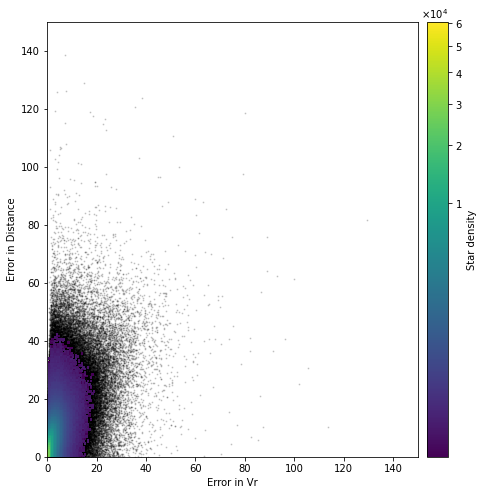

In [92]:
from matplotlib import colors
x = np.sqrt(C_new_cylindrical[:, 3, 3])
y = np.sqrt(C_new_cylindrical[:, 2, 2])
fig = plt.figure(figsize=(8, 8))

range = [[0, 150], [0, 150]]
h = plt.hist2d(x, y, bins=250, range=range, cmin=20, norm=colors.PowerNorm(0.3), zorder=0.5)
plt.scatter(x, y, alpha=0.15, s=1, color='k', zorder=0)

fmt = mpl.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
plt.colorbar(h[3], pad=0.02, format=fmt, orientation='vertical', label = 'Star density')
plt.xlabel('Error in Vr')
plt.ylabel('Error in Distance')


Text(0, 0.5, 'Error in Distance')

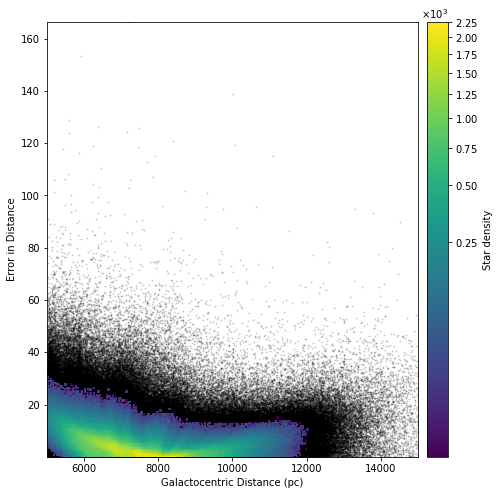

In [104]:
from matplotlib import colors
x = galcen_data.r
y = np.sqrt(C_new_cylindrical[:, 2, 2])
fig = plt.figure(figsize=(8, 8))

range = [[0, 150], [0, 150]]
h = plt.hist2d(x, y, bins=250, cmin=40, norm=colors.PowerNorm(0.3), zorder=0.5)
plt.scatter(x, y, alpha=0.15, s=1, color='k', zorder=0)

fmt = mpl.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
plt.colorbar(h[3], pad=0.02, format=fmt, orientation='vertical', label = 'Star density')
plt.xlabel('Galactocentric Distance (pc)')
plt.ylabel('Error in Distance')

Text(0, 0.5, 'Error in Vr')

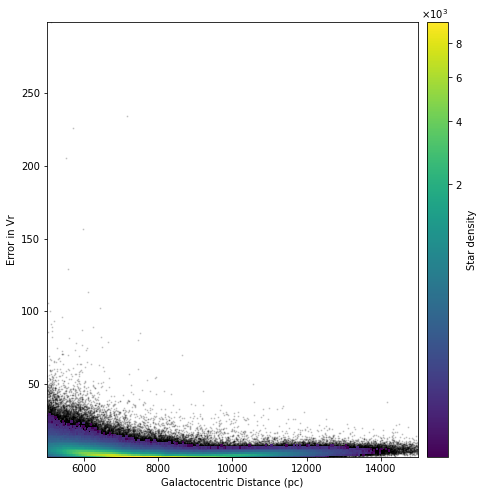

In [108]:
from matplotlib import colors
x = galcen_data.r
y = np.sqrt(C_new_cylindrical[:, 3, 3])
fig = plt.figure(figsize=(8, 8))

range = [[0, 150], [0, 150]]
h = plt.hist2d(x, y, bins=250, cmin=20, norm=colors.PowerNorm(0.3), zorder=0.5)
plt.scatter(x, y, alpha=0.15, s=1, color='k', zorder=0)

fmt = mpl.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
plt.colorbar(h[3], pad=0.02, format=fmt, orientation='vertical', label = 'Star density')
plt.xlabel('Galactocentric Distance (pc)')
plt.ylabel('Error in Vr')

Text(0, 0.5, 'Error in Vphi')

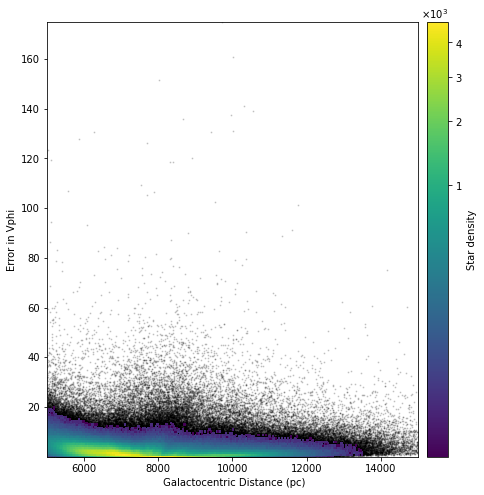

In [110]:
from matplotlib import colors
x = galcen_data.r
y = np.sqrt(C_new_cylindrical[:, 4, 4])
fig = plt.figure(figsize=(8, 8))

range = [[0, 150], [0, 150]]
h = plt.hist2d(x, y, bins=250, cmin=20, norm=colors.PowerNorm(0.3), zorder=0.5)
plt.scatter(x, y, alpha=0.15, s=1, color='k', zorder=0)

fmt = mpl.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
plt.colorbar(h[3], pad=0.02, format=fmt, orientation='vertical', label = 'Star density')
plt.xlabel(' Galactocentric Distance (pc)')
plt.ylabel('Error in Vphi')

Text(0.5, 1.0, '$\\sigma_{Vr}$')

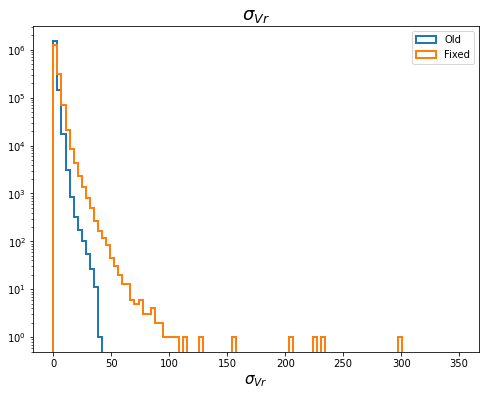

In [79]:
i = 3

fig = plt.figure(figsize=(8, 6))
h2 = plt.hist(np.sqrt(C_old_cylindrical[:, i, i]), 
            100, 
            range=(0, 350), 
            label='Old', 
            histtype='step', 
            linewidth=2)

h1 = plt.hist(np.sqrt(C_new_cylindrical[:, i, i]), 
            100, 
            range=(0, 350), 
            label='Fixed', 
            histtype='step',
            linewidth=2)
#plt.xlim(0, 50000)
plt.legend()
plt.yscale('log')

plt.xlabel(r'$\sigma_{Vr}$', fontdict={'fontsize' : 15})
plt.title(r'$\sigma_{Vr}$', fontsize = 18)

Text(0.5, 1.0, '$\\sigma_{V\\phi}$')

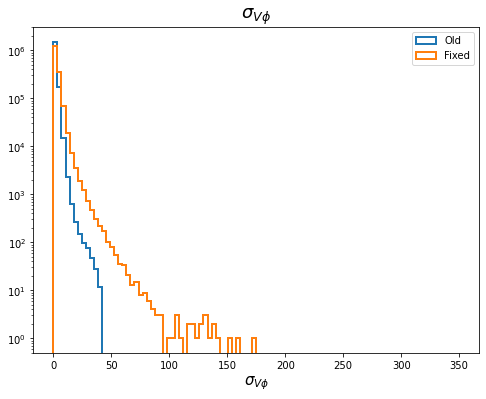

In [81]:
i = 4

fig = plt.figure(figsize=(8, 6))
h2 = plt.hist(np.sqrt(C_old_cylindrical[:, i, i]), 
            100, 
            range=(0, 350), 
            label='Old', 
            histtype='step', 
            linewidth=2)

h1 = plt.hist(np.sqrt(C_new_cylindrical[:, i, i]), 
            100, 
            range=(0, 350), 
            label='Fixed', 
            histtype='step',
            linewidth=2)
#plt.xlim(0, 50000)
plt.legend()
plt.yscale('log')

plt.xlabel(r'$\sigma_{V\phi}$', fontdict={'fontsize' : 15})
plt.title(r'$\sigma_{V\phi}$', fontsize = 18)